In [1]:
import sys
from datetime import datetime, timedelta
from dateutil import tz
from uuid import UUID

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

In [2]:
msdf = pd.read_pickle("BiVO4_icpms_data.pickle")
ecdf = pd.read_pickle("BiVO4_eche_data.pickle")
indf = pd.read_pickle("BiVO4_inject_data.pickle")

In [3]:
els = ['Bi', 'V']
MASSD = {'Bi': 208.9804, 'V': 50.9415}

# stacked plots

In [4]:
icpms_columns = [f"{k}_ppb" for k in els]
seqs = ecdf.drop_duplicates("sequence_uuid").sequence_uuid

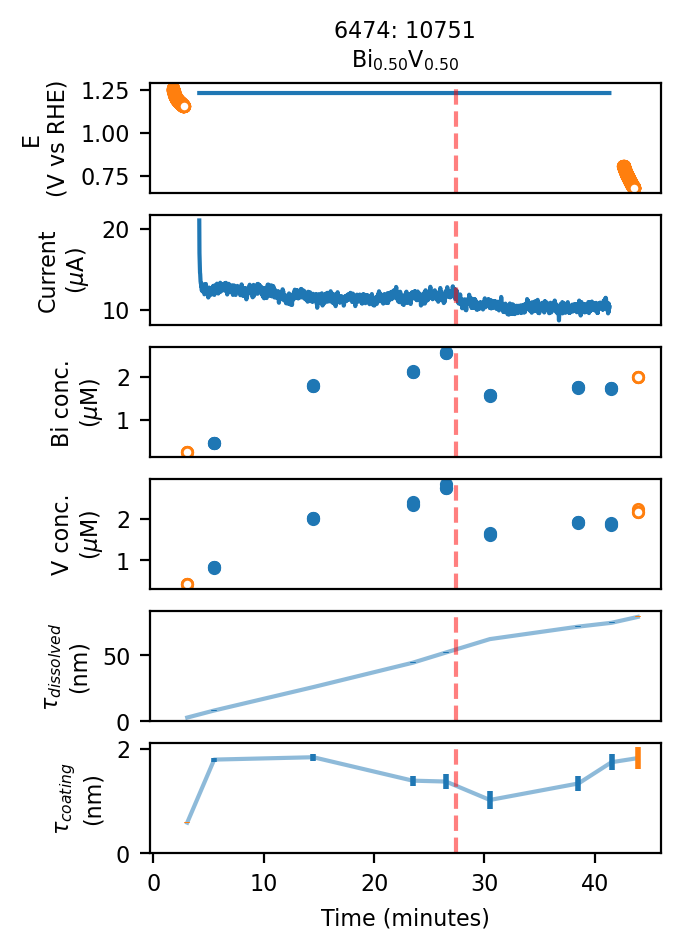

In [5]:
SMALL_SIZE = 8
MEDIUM_SIZE = 8
BIGGER_SIZE = 10
SCATTER_SIZE = 14

plt.rc("font", size=SMALL_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=SMALL_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=SMALL_SIZE)  # legend fontsize
plt.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title

fig, ax = plt.subplots(
    4 + len(icpms_columns),
    1,
    sharey="row",
    sharex="col",
    figsize=(3.3, 5),
    dpi=200,
)

seq = UUID("22287238-54cd-4315-b7a7-4d3627a6f375")
seche = ecdf.query("sequence_uuid == @seq")
compstr = "".join(
    [
        f"{k}$_" + "{" + f"{v:.2f}" + "}$"
        for k, v in sorted(seche.iloc[0].composition.items())
        if k != "code"
    ]
)
plate_id = seche.iloc[0].plate_id
sample_no = seche.iloc[0].sample_no
spal = msdf.query("sequence_uuid == @seq")
# row 0: potential vs time
for _, carow in seche.query("action_name=='run_CA'").iterrows():
    times = [
        (
            datetime.fromtimestamp(carow.action_epoch, tz=tz.gettz("UTC"))
            + timedelta(seconds=t)
            - carow.sequence_timestamp.tz_localize("UTC")
        ).seconds
        / 60
        for t in carow.t_s
    ]
    ax[0].plot(times, carow.Erhe_V)
for _, ocvrow in seche.query("action_name=='run_OCV'").iterrows():
    times = [
        (
            datetime.fromtimestamp(ocvrow.action_epoch, tz=tz.gettz("UTC"))
            + timedelta(seconds=t)
            - ocvrow.sequence_timestamp.tz_localize("UTC")
        ).seconds
        / 60
        for t in ocvrow.t_s
    ]
    ax[0].scatter(
        times, ocvrow.Erhe_V, facecolor="w", edgecolor=mpl.cm.tab10(1), s=SCATTER_SIZE
    )
# row 1: current vs time
for _, carow in seche.query("action_name=='run_CA'").iterrows():
    times = [
        (
            datetime.fromtimestamp(carow.action_epoch, tz=tz.gettz("UTC"))
            + timedelta(seconds=t)
            - carow.sequence_timestamp.tz_localize("UTC")
        ).seconds
        / 60
        for t in carow.t_s
    ]
    ax[1].plot(times, np.array(carow.I_A) * 1e6)
    # ax[1].set_yscale("log")
# remaining rows: icpms ppb
for j, col in enumerate(els):
    moles = {"CA": [], "OCV": []}
    times = {"CA": [], "OCV": []}

    for _, msrow in spal.iterrows():
        for ppbval in msrow[f"{col}_ppb"]:
            cell_ml = msrow.cell_volume_ul * 1e-3
            aliquot_ml = msrow.aliquot_volume_ul * 1e-3
            moles_in_cell = cell_ml * 1e-3 * ppbval * 1e-6 / MASSD[col]
            # molarity = ppbval * 1e-6 / MASSD[col]
            molarity = ppbval / MASSD[col]  # micromolar
            pkey = "CA" if "CA" in msrow.experiment_name else "OCV"
            moles[pkey].append(molarity)
            times[pkey].append(
                (
                    datetime.fromtimestamp(
                        msrow.aliquot_epoch, tz=tz.gettz("Pacific / Los Angeles")
                    ).replace(tzinfo=tz.gettz("UTC"))
                    - msrow.sequence_timestamp.tz_localize("UTC")
                ).seconds
                / 60
            )

    ax[2 + j].scatter(
        times["OCV"],
        moles["OCV"],
        facecolor="w",
        edgecolor=mpl.cm.tab10(1),
        s=SCATTER_SIZE,
    )
    ax[2 + j].scatter(
        times["CA"], moles["CA"], facecolor=mpl.cm.tab10(0), s=SCATTER_SIZE
    )
    ax[2 + j].set_ylabel(f"{col} conc.\n($\mu$M)")
ocv_icpms = spal.query("experiment_name.str.contains('OCV')")
ca_icpms = spal.query("experiment_name.str.contains('CA')")

sns.lineplot(
    spal,
    x="aliquot_elapsed_min",
    y="BiVO4_dissolved_nm",
    ax=ax[len(els) + 2],
    alpha=0.5,
)
ax[len(els) + 2].errorbar(
    ocv_icpms.aliquot_elapsed_min,
    ocv_icpms.BiVO4_dissolved_nm,
    yerr=ocv_icpms.BiVO4_dissolved_nm_stdev,
    ecolor=mpl.cm.tab10(1),
    zorder=9,
    lw=0,
    elinewidth=2,
)
ax[len(els) + 2].errorbar(
    ca_icpms.aliquot_elapsed_min,
    ca_icpms.BiVO4_dissolved_nm,
    yerr=ca_icpms.BiVO4_dissolved_nm_stdev,
    ecolor=mpl.cm.tab10(0),
    lw=0,
    elinewidth=2,
)

sns.lineplot(
    spal,
    x="aliquot_elapsed_min",
    y="Bi4O7_coating_nm",
    ax=ax[len(els) + 3],
    alpha=0.5,
)
ax[len(els) + 3].errorbar(
    ocv_icpms.aliquot_elapsed_min,
    ocv_icpms.Bi4O7_coating_nm,
    yerr=ocv_icpms.Bi4O7_coating_nm_stdev,
    ecolor=mpl.cm.tab10(1),
    zorder=9,
    lw=0,
    elinewidth=2,
)
ax[len(els) + 3].errorbar(
    ca_icpms.aliquot_elapsed_min,
    ca_icpms.Bi4O7_coating_nm,
    yerr=ca_icpms.Bi4O7_coating_nm_stdev,
    ecolor=mpl.cm.tab10(0),
    lw=0,
    elinewidth=2,
)

ax[len(els) + 2].set_ylim(0, None)
ax[len(els) + 3].set_ylim(0, 2.1)

ax[0].set_ylabel("E\n(V vs RHE)")
ax[1].set_ylabel("Current\n($\mu$A)")
ax[len(els) + 2].set_ylabel("$\\tau_{dissolved}$\n(nm)")
ax[len(els) + 3].set_ylabel("$\\tau_{coating}$\n(nm)")
for ri in range(3 + len(els)):
    ax[ri].xaxis.set_visible(False)
ax[0].set_title(f"{plate_id}: {sample_no}\n{compstr}")
ax[len(els) + 3].set_xlabel("Time (minutes)")

ssol = indf.query("sequence_uuid == @seq")[["action_epoch"]]
if ssol.shape[0] > 0:
    infuse_epoch = ssol.iloc[0].action_epoch
    for rowi in range(4 + len(icpms_columns)):
        ax[rowi].axvline(
            x=(
                datetime.fromtimestamp(infuse_epoch, tz=tz.gettz("UTC"))
                - carow.sequence_timestamp.tz_localize("UTC")
            ).seconds
            / 60,
            ls="--",
            c="red",
            alpha=0.5,
            label="inject",
        )
# fig.tight_layout()

plt.savefig("BiVO4.svg", facecolor="w")

In [6]:
figdf = msdf.query("sequence_uuid == @seq")
figtable = pd.DataFrame(
    {
        # "sample_no": figdf.sample_no,
        "aliquot_time_min": figdf.aliquot_elapsed_min,
        "V_i": figdf.cell_volume_ul - figdf.aliquot_volume_ul,
        "Bi_uM": figdf.Bi_mol_L.apply(lambda x: [y * 1e6 for y in x]),
        "V_uM": figdf.V_mol_L.apply(lambda x: [y * 1e6 for y in x]),
        "m_A": figdf.V_mol_cumulative_total,
        "m_A_stdev": figdf.V_mol_cumulative_total_stdev,
        "m_B": figdf.Bi_mol_cumulative_total,
        "m_B_stdev": figdf.Bi_mol_cumulative_total_stdev,
        "tau_dissolved_nm": figdf.BiVO4_dissolved_nm,
        "tau_dissolved_nm_stdev": figdf.BiVO4_dissolved_nm_stdev,
        "tau_coating_nm": figdf.Bi4O7_coating_nm,
        "tau_coating_nm_stdev": figdf.Bi4O7_coating_nm_stdev,
    }
)

In [7]:
# manually insert starting volume (not an actual aliquot action)
figtable = pd.concat(
    (pd.DataFrame({"aliquot_time_min": 0, "V_i": 4000}, index=[0]), figtable)
).reset_index(drop=True)

with pd.option_context("display.max_colwidth", 100):
    print(figtable)

   aliquot_time_min   V_i  \
0          0.000000  4000   
1          3.075258  3900   
2          5.516592  3800   
3         14.497263  3700   
4         23.504733  3600   
5         26.512925  3500   
6         30.494515  6900   
7         38.516574  6800   
8         41.510615  6700   
9         43.890449  6600   

                                                             Bi_uM  \
0                                                              NaN   
1  [0.24445127833119992, 0.24562550997584465, 0.24101063458660565]   
2   [0.45047563649804523, 0.4590181790683509, 0.45818824061114727]   
3       [1.8219987800091915, 1.789459325507076, 1.788270383900268]   
4      [2.1315929168346077, 2.124803434500994, 2.1172630416788683]   
5        [2.5582352260565764, 2.55807878637147, 2.573065708204655]   
6      [1.5629972373471612, 1.581989015119068, 1.5777338556841765]   
7      [1.7558873690832588, 1.747064170843262, 1.7651173105045326]   
8      [1.7489727350015591, 1.7170903271768905, 1.